In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import pickle

from matplotlib import image
from tqdm import tqdm

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [2]:
DATA_PATH = os.getcwd() + '/Data/'

---

# Creating Benchamark Images

In [128]:
ids = next(os.walk(f"{DATA_PATH}benchmark/baseline/"))[2]
print("No. of images = ", len(ids))

No. of images =  288


In [129]:
img_list = ids[:180]

In [5]:
def zoom(img,scale_max,seed):
    np.random.seed(seed)
    rn = np.random.rand()
    scale = (1 + rn*scale_max)
    start_x = int(rn*np.shape(img)[1])
    start_y = int(rn*np.shape(img)[0])
    return cv.resize(img,None,fx = scale,fy = scale, interpolation = cv.INTER_CUBIC)[start_y:start_y + np.shape(img)[0],start_x:start_x +np.shape(img)[1]]
def shift(img,dist_max,seed):
    np.random.seed(seed)
    rn = np.random.rand()
    dir_x = np.random.randint(-1,2)
    dir_y = np.random.randint(-1,2)
    dist = rn*dist_max 
    translation_matrix = np.float32([ [1,0,dir_x*dist], [0,1,dir_y*dist] ])
    return cv.warpAffine(img, translation_matrix, np.shape(img)[:2], borderMode = cv.BORDER_REPLICATE)
def rotate(img,seed):
    np.random.seed(seed)
    angle = int(np.random.uniform(-180, 180))
    rotation_matrix = cv.getRotationMatrix2D((int(np.shape(img)[1]/2), int(np.shape(img)[0]/2)), angle, 1)
    return cv.warpAffine(img, rotation_matrix, np.shape(img)[:2], borderMode = cv.BORDER_REPLICATE)
def flip(img,seed):
    np.random.seed(seed)
    np.random.randint(0,2)
    return cv.flip(img, np.random.randint(0,2))

In [10]:
high = 4
r_size = 0.7

Y = np.zeros(len(img_list))
for i in range(len(img_list)):
    img = cv.imread(f'{DATA_PATH}benchmark/baseline/{img_list[i]}',0)
    img = 255 - np.array(img)
    circles = cv.HoughCircles(img, cv.HOUGH_GRADIENT, 1.2, 100)
    img = img/255.0
    
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x, y, r) in circles:
            src = img[y-int(r*r_size):y+int(r*r_size),x-int(r*r_size):x+int(r*r_size)].copy()
            rn1 = np.random.randint(0,high)
            if rn1 == 0:
                Y[i] = 1
                rn2 = np.random.randint(0,1)
                if rn2 == 0:
                    # Shift
                    src = shift(src, 256, i)
                rn3 = np.random.randint(0,1)
                if rn3 == 0:
                    # Zoom
                    src = zoom(src, 3, i)
                rn4 = np.random.randint(0,1)
                if rn4 == 0:
                    # Rotate
                    src = rotate(src, i)
                rn5 = np.random.randint(0,1)
                if rn5 == 0:
                    # Flip 
                    src = flip(src, i)
            img[y-int(r*r_size):y+int(r*r_size),x-int(r*r_size):x+int(r*r_size)] = src
    outname = img_list[i].replace('.tif','.png')
    cv.imwrite(f'{DATA_PATH}benchmark/modified/{outname}',img*255)
    #plt.imshow(img,"gray")
    #plt.show()
outfile = open(f'{DATA_PATH}benchmark/y.pickle',"wb")
pickle.dump(1-Y,outfile)
outfile.close()

In [43]:
infile = open(f'{DATA_PATH}benchmark/y.pickle',"rb")
Y = pickle.load(infile)
infile.close()

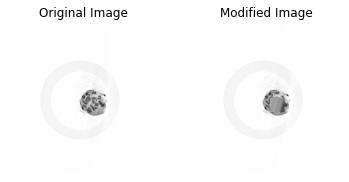

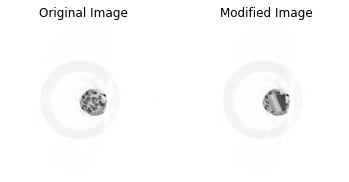

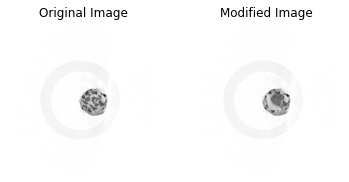

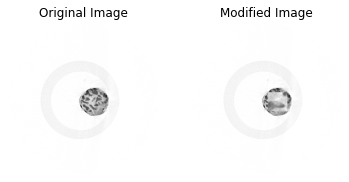

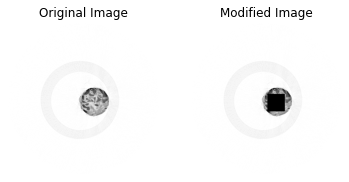

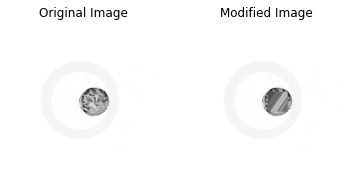

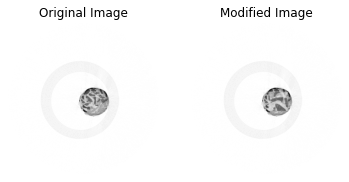

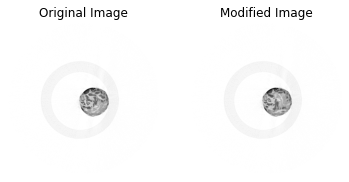

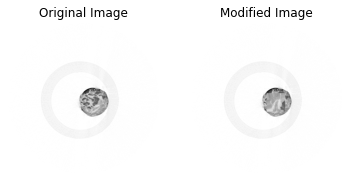

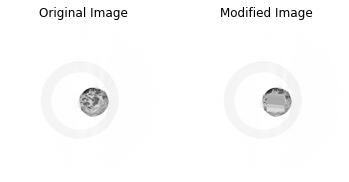

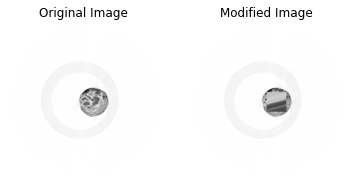

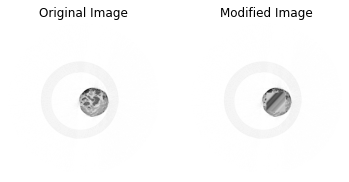

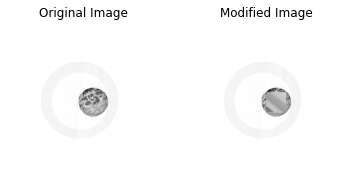

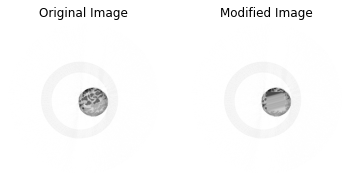

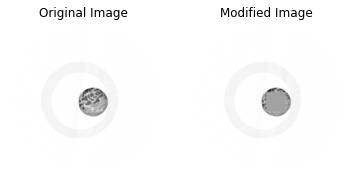

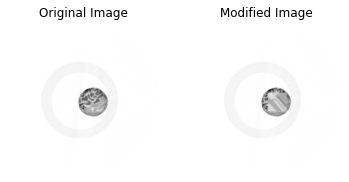

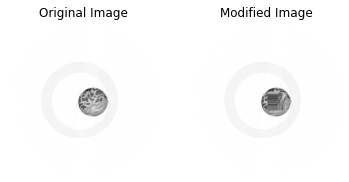

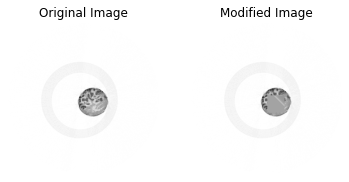

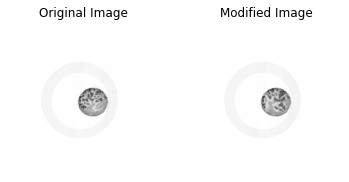

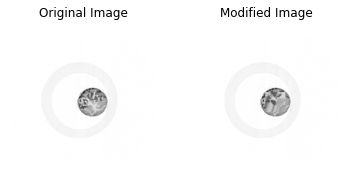

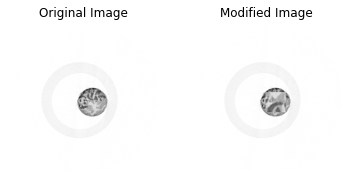

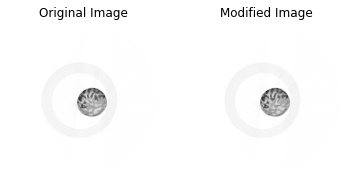

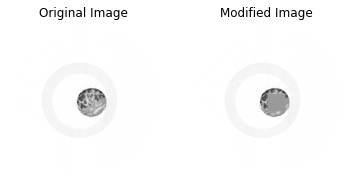

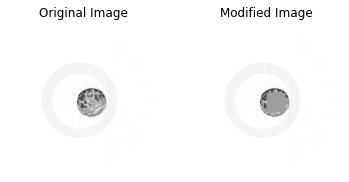

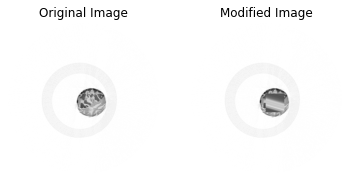

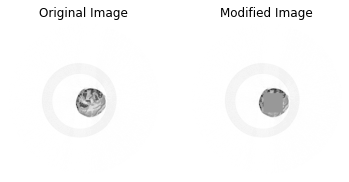

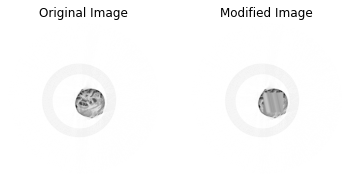

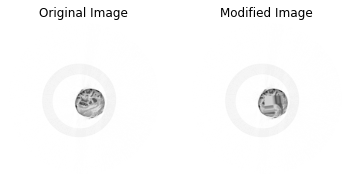

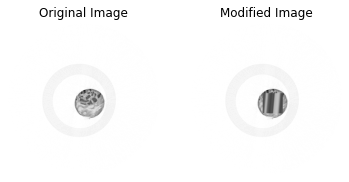

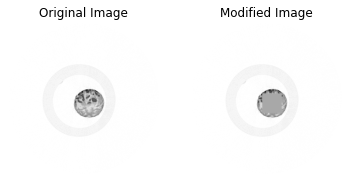

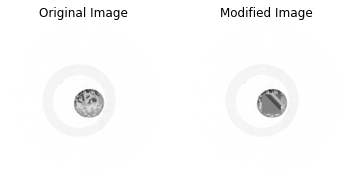

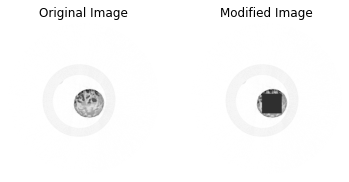

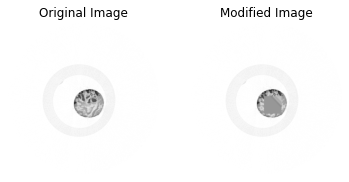

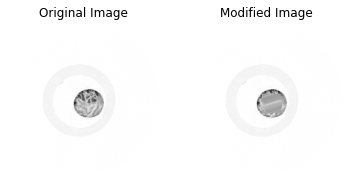

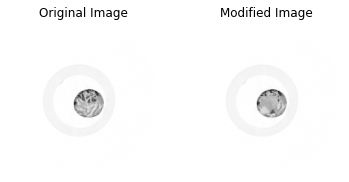

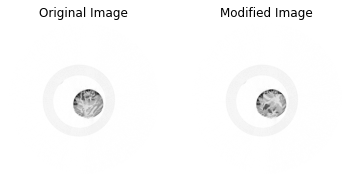

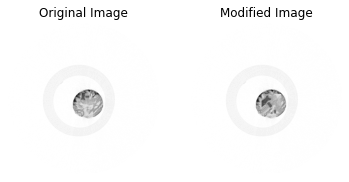

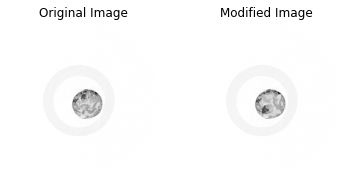

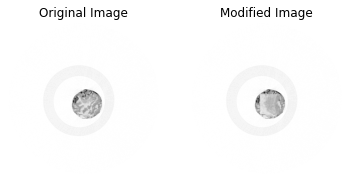

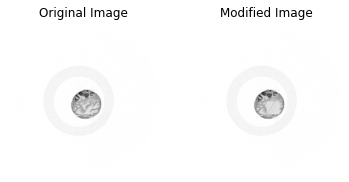

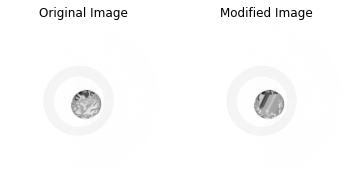

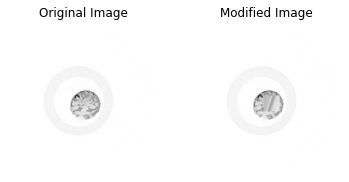

In [14]:
for i in range(len(img_list)):
    if Y[i] == 0:
        img_orig = cv.imread(f'{DATA_PATH}benchmark/baseline/{img_list[i]}',0)
        img_orig = 255 - np.array(img_orig)
        img_mod_name = img_list[i].replace('.tif','.png')
        img_mod = cv.imread(f'{DATA_PATH}benchmark/modified/{img_mod_name}',0)
        fig, ax = plt.subplots(1,2)
        ax[0].set_title("Original Image")
        ax[0].imshow(img_orig,"gray")
        ax[0].axis('off')
        ax[1].set_title("Modified Image")
        ax[1].imshow(img_mod,"gray")
        ax[1].axis('off')
        plt.show()

---

# Benchmarking the Filter Methods
## Exploration

In [3]:
infile = open(f'{DATA_PATH}benchmark/y.pickle',"rb")
Y = pickle.load(infile)
infile.close()

In [3]:
def imshow_with_numbers(img,ticks,sup_title,tiny_imgs_path): 
    if len(ticks) > 10:
        fs = 'small'
    elif len(ticks) > 20:
        fs = 'x-small'
    elif len(ticks) > 30:
        fs = 'xx-small'
    else:
        fs = 'medium'
    fig = plt.figure(figsize=(16, 12))
    ax = fig.add_subplot(111)
    im = ax.imshow(img)
    for (j,i),label in np.ndenumerate(img):
        ax.text(i,j,round(label,3),ha='center',va='center',size=fs)
    #ax.set_xticks(list(range(len(img))))
    #ax.set_xticklabels(ticks,size=fs)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.xaxis.set_tick_params(rotation=-90)
    ax.set_yticks(list(range(len(img))))
    ax.set_yticklabels(ticks,size=fs)
    ax.set_title("Mutual Information")
    fig.colorbar(im)
    
    xl, yl, xh, yh=np.array(ax.get_position()).ravel()
    w=xh-xl
    h=yh-yl
    size=w*(1/len(list(range(len(img)))))
    for i in range(len(ticks)):
        xp=xl+w*(i/len(list(range(len(img)))))
        ax1=fig.add_axes([xp-0.5*size, yl-2.7*size, 2*size, 2*size])
        ax1.axison = False
        imgplot = ax1.imshow(cv.cvtColor(cv.imread(f'{tiny_imgs_path}{ticks[i]}'), cv.COLOR_BGR2RGB))
    fig.suptitle(sup_title,y=0.93)
    plt.show()

In [5]:
infile = open(f'{DATA_PATH}minf_sym_benchmark.pickle','rb')
minf_sym_benchmark = pickle.load(infile)
infile.close()
minf_sym_benchmark = minf_sym_benchmark+minf_sym_benchmark.T-np.eye(len(minf_sym_benchmark))*minf_sym_benchmark

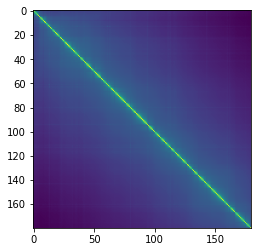

In [6]:
_ = plt.imshow(minf_sym_benchmark)

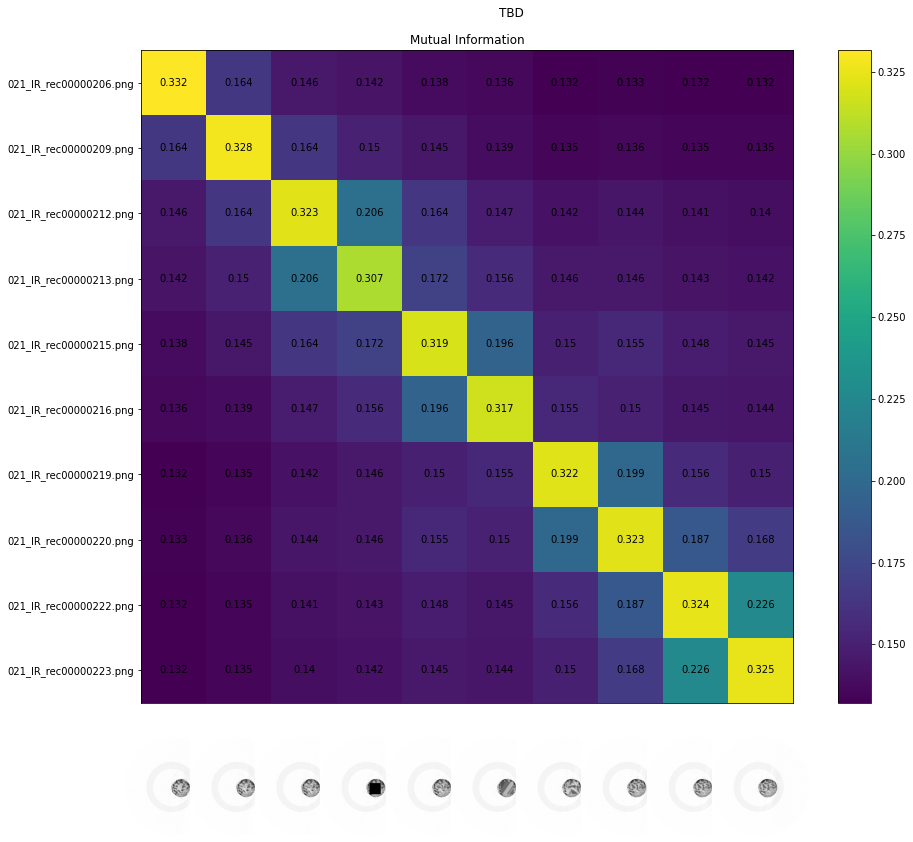

In [7]:
min_num = 10
max_num = 20
ids = next(os.walk(f"{DATA_PATH}benchmark/modified/"))[2]
imshow_with_numbers(minf_sym_benchmark[min_num:max_num,min_num:max_num],ids[min_num:max_num],"TBD",f'{DATA_PATH}benchmark/modified/')

In [8]:
infile = open(f'{DATA_PATH}minf_sym_benchmark_baseline.pickle','rb')
minf_sym_benchmark_baseline = pickle.load(infile)
infile.close()
minf_sym_benchmark_baseline = minf_sym_benchmark_baseline+minf_sym_benchmark_baseline.T-np.eye(len(minf_sym_benchmark_baseline))*minf_sym_benchmark_baseline

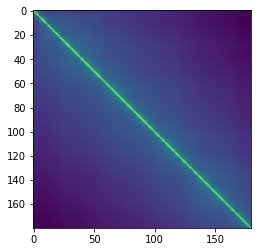

In [9]:
_ = plt.imshow(minf_sym_benchmark_baseline)

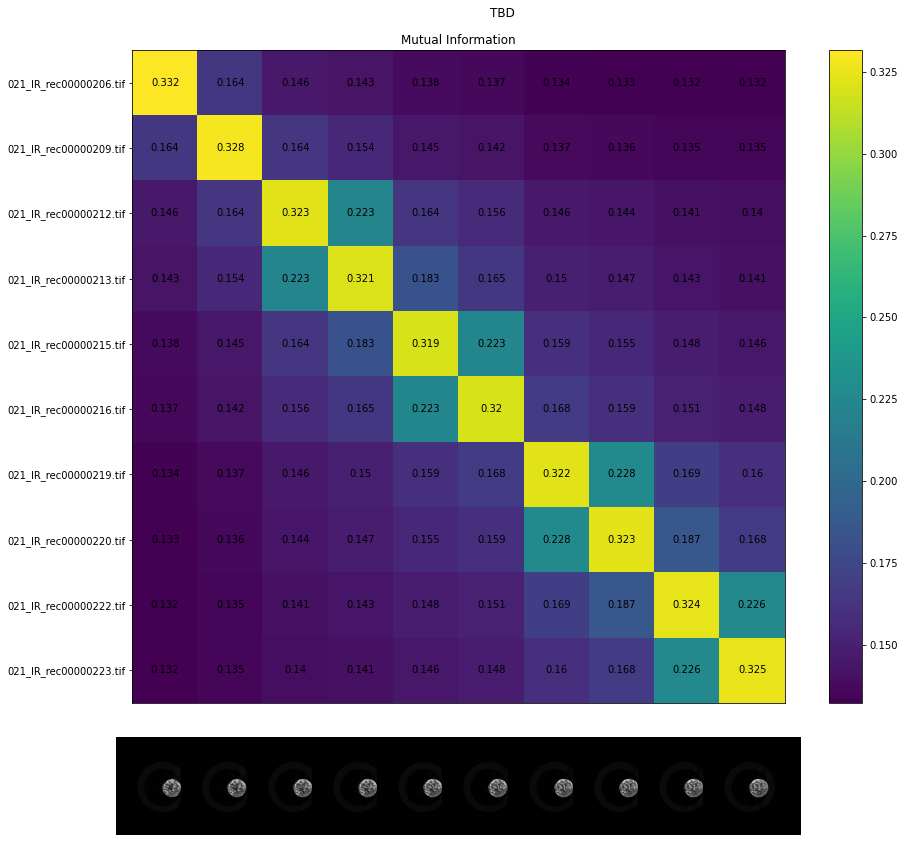

In [10]:
min_num = 10
max_num = 20
ids = next(os.walk(f"{DATA_PATH}benchmark/baseline/"))[2]
imshow_with_numbers(minf_sym_benchmark_baseline[min_num:max_num,min_num:max_num],ids[min_num:max_num],"TBD",f'{DATA_PATH}benchmark/baseline/')

In [11]:
ids = next(os.walk(f"{DATA_PATH}benchmark/modified/"))[2]
print("No. of images = ", len(ids))

No. of images =  180


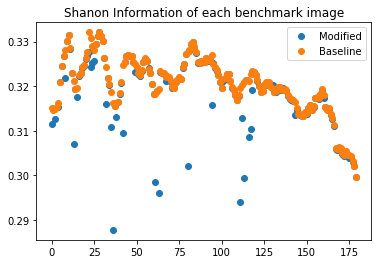

In [12]:
plt.title("Shanon Information of each benchmark image")
plt.plot(np.diag(minf_sym_benchmark), "o",label = "Modified")
plt.plot(np.diag(minf_sym_benchmark_baseline), "o",label ="Baseline")
plt.legend()

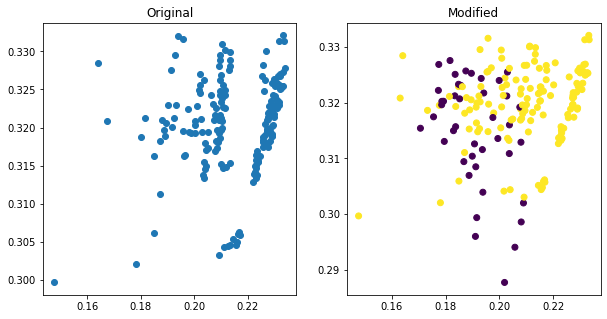

In [13]:
upper = np.diag(minf_sym_benchmark,k=1)
lower = np.diag(minf_sym_benchmark,k=-1)
upper = np.insert(upper,len(upper),lower[len(lower)-1]) 
lower = np.insert(lower,0,upper[0])
xs = np.mean(np.vstack((upper,lower)),axis = 0)
ys = np.diag(minf_sym_benchmark)
entr = np.stack((xs,ys))

upper = np.diag(minf_sym_benchmark_baseline,k=1)
lower = np.diag(minf_sym_benchmark_baseline,k=-1)
upper = np.insert(upper,len(upper),lower[len(lower)-1]) 
lower = np.insert(lower,0,upper[0])
xs = np.mean(np.vstack((upper,lower)),axis = 0)
ys = np.diag(minf_sym_benchmark_baseline)
entr_baseline = np.stack((xs,ys))

fig, ax = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(10)
ax[0].set_title("Original")
ax[0].scatter(entr_baseline[0],entr_baseline[1])
ax[1].set_title("Modified")
ax[1].scatter(entr[0],entr[1],c=Y)
plt.show()

In [25]:
def cluster_filter(model,iter_mx,iter_names,model_name,do_scatter_plot = False):
    img_list = iter_names.copy()
    dropped_names = []

    upper = np.diag(iter_mx,k=1)
    lower = np.diag(iter_mx,k=-1)
    upper = np.insert(upper,len(upper),lower[len(lower)-1]) 
    lower = np.insert(lower,0,upper[0])
    xs = np.mean(np.vstack((upper,lower)),axis = 0)
    ys = np.diag(iter_mx)
    entr = np.stack((xs,ys))

    preds = model.fit_predict(entr.T)
    u,c = np.unique(preds,return_counts=True)
    for i in range(len(u)):
        if (c==min(c))[i]:
            negative_class = u[i]
    for i in range(len(iter_names[:len(xs)])):
        if (preds==negative_class)[i] and do_scatter_plot:
            print(iter_names[i])
    drop_list = []
    for i in range(len(entr.T)):
        if (preds==negative_class)[i]:
            dropped_names.append(iter_names[i])
            drop_list.append(i)
    y_pred = np.zeros(len(img_list))
    for i in range(len(img_list)):
        if img_list[i] in dropped_names:
            y_pred[i] = 1
    y_pred = 1-y_pred
    if do_scatter_plot:
        plt.figure(figsize=(10,7))
        plt.title(f"{model_name} of the Mutual information matrix up to first neighbors")
        cdict = {0: 'red', 1: 'blue'}
        namedict = {0: 'Failed section', 1: 'Good section'}
        for i in [0,1]:
            ix = np.where(y_pred == i)
            plt.scatter(entr[0][ix],entr[1][ix],c=cdict[i],label = namedict[i])
        plt.xlabel("Avg. Mutual information with first neighbor")
        plt.ylabel("Shannon information")
        plt.legend()
        plt.grid()
        plt.show()
    
    return y_pred,dropped_names

In [5]:
def cluster_filter_n(model,iter_mx,iter_names,neighbors=2):
    img_list = iter_names.copy()
    dropped_names = []

    entr = np.diag(iter_mx)
    for i in range(0,neighbors):
        k = i+1
        upper = np.diag(iter_mx,k=k)
        lower = np.diag(iter_mx,k=-k)
        upper = np.insert(upper,len(upper),lower[len(lower)-k:]) 
        lower = np.insert(lower,0,upper[:k])
        ys = np.mean(np.vstack((upper,lower)),axis = 0)
        entr = np.vstack((entr,ys))

    preds = model.fit_predict(entr.T)
    #if do_scatter_plot:
    #    fig = plt.figure()
    #    ax = fig.add_subplot(projection='3d')
    #    ax.scatter(xs, ys, zs, c=preds)
    #    plt.show()
    u,c = np.unique(preds,return_counts=True)
    for i in range(len(u)):
        if (c==min(c))[i]:
            negative_class = u[i]
    #for i in range(len(iter_names[:len(xs)])):
    #    if (preds==negative_class)[i] and do_scatter_plot:
    #        print(iter_names[i])
    drop_list = []
    for i in range(len(entr.T)):
        if (preds==negative_class)[i]:
            dropped_names.append(iter_names[i])
            drop_list.append(i)
    y_pred = np.zeros(len(img_list))
    for i in range(len(img_list)):
        if img_list[i] in dropped_names:
            y_pred[i] = 1
    y_pred = 1-y_pred

    return y_pred,dropped_names

In [6]:
def evaluate_neighbors(model,iter_mx,iter_names,Y,n_max,model_name):
    accs = []
    prcs = []
    rclls = []
    fs = []
    for n in range(1,n_max):
        y_pred,_ = cluster_filter_n(model,iter_mx,iter_names,neighbors=n)
        accs.append(accuracy_score(Y,y_pred))
        prcs.append(precision_score(Y,y_pred))
        rclls.append(recall_score(Y,y_pred))
        fs.append(f1_score(Y,y_pred))


    best = list(range(1,n_max))[np.argmax(fs)]
    print(f"best:{best}")
    
    xvals = list(range(1,n_max))
    plt.title(f"Filtering ability of {model_name} up to {n_max}th neighbors")
    plt.plot(xvals,accs,label = "Accuracy")
    plt.plot(xvals,prcs,label = "Precision")
    plt.plot(xvals,rclls,label = "Recall")
    plt.vlines(best,min([min(accs),min(prcs),min(rclls)]),max([max(accs),max(prcs),max(rclls)]),"red",label=f"best, F-score = {round(fs[np.argmax(fs)],2)}")
    plt.xlabel("Neighbors included")
    plt.ylabel("Score")
    plt.grid()
    plt.legend()
    plt.show()

## K-Means

In [7]:
from sklearn.cluster import KMeans

021_IR_rec00000193.png
021_IR_rec00000194.png
021_IR_rec00000195.png
021_IR_rec00000196.png
021_IR_rec00000197.png
021_IR_rec00000200.png
021_IR_rec00000202.png
021_IR_rec00000204.png
021_IR_rec00000206.png
021_IR_rec00000209.png
021_IR_rec00000212.png
021_IR_rec00000213.png
021_IR_rec00000215.png
021_IR_rec00000216.png
021_IR_rec00000219.png
021_IR_rec00000220.png
021_IR_rec00000225.png
021_IR_rec00000230.png
021_IR_rec00000231.png
021_IR_rec00000233.png
021_IR_rec00000234.png
021_IR_rec00000236.png
021_IR_rec00000242.png
021_IR_rec00000243.png
021_IR_rec00000246.png
021_IR_rec00000247.png
021_IR_rec00000248.png
021_IR_rec00000249.png
021_IR_rec00000252.png
021_IR_rec00000254.png
021_IR_rec00000256.png
021_IR_rec00000257.png
021_IR_rec00000263.png
021_IR_rec00000264.png
021_IR_rec00000266.png
021_IR_rec00000271.png
021_IR_rec00000274.png
021_IR_rec00000275.png
021_IR_rec00000277.png
021_IR_rec00000279.png
021_IR_rec00000281.png
021_IR_rec00000284.png
021_IR_rec00000286.png
021_IR_rec0

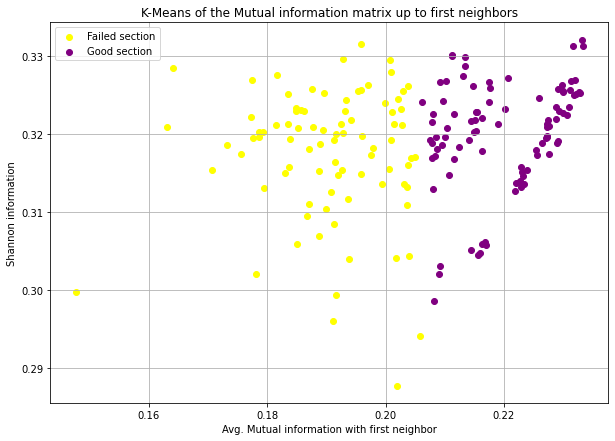

In [18]:
km = KMeans(n_clusters=2)
y_pred,_ = cluster_filter(km,minf_sym_benchmark,ids,"K-Means",do_scatter_plot = True)

In [19]:
print(accuracy_score(Y,y_pred))
print(precision_score(Y,y_pred))
print(recall_score(Y,y_pred))

0.7111111111111111
0.9574468085106383
0.6521739130434783


best:5


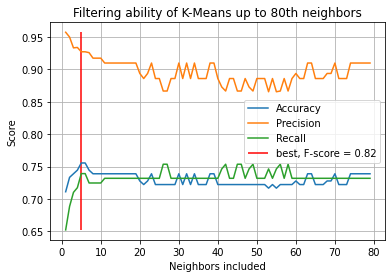

In [20]:
evaluate_neighbors(KMeans(n_clusters=2),minf_sym_benchmark,ids,Y,80,"K-Means")

## Spectral Clustering

In [8]:
from sklearn.cluster import SpectralClustering

021_IR_rec00000193.png
021_IR_rec00000194.png
021_IR_rec00000195.png
021_IR_rec00000196.png
021_IR_rec00000197.png
021_IR_rec00000200.png
021_IR_rec00000202.png
021_IR_rec00000204.png
021_IR_rec00000206.png
021_IR_rec00000209.png
021_IR_rec00000212.png
021_IR_rec00000213.png
021_IR_rec00000215.png
021_IR_rec00000216.png
021_IR_rec00000219.png
021_IR_rec00000220.png
021_IR_rec00000225.png
021_IR_rec00000230.png
021_IR_rec00000231.png
021_IR_rec00000233.png
021_IR_rec00000234.png
021_IR_rec00000236.png
021_IR_rec00000242.png
021_IR_rec00000243.png
021_IR_rec00000246.png
021_IR_rec00000247.png
021_IR_rec00000248.png
021_IR_rec00000249.png
021_IR_rec00000252.png
021_IR_rec00000254.png
021_IR_rec00000256.png
021_IR_rec00000257.png
021_IR_rec00000263.png
021_IR_rec00000264.png
021_IR_rec00000266.png
021_IR_rec00000271.png
021_IR_rec00000274.png
021_IR_rec00000275.png
021_IR_rec00000277.png
021_IR_rec00000279.png
021_IR_rec00000281.png
021_IR_rec00000284.png
021_IR_rec00000286.png
021_IR_rec0

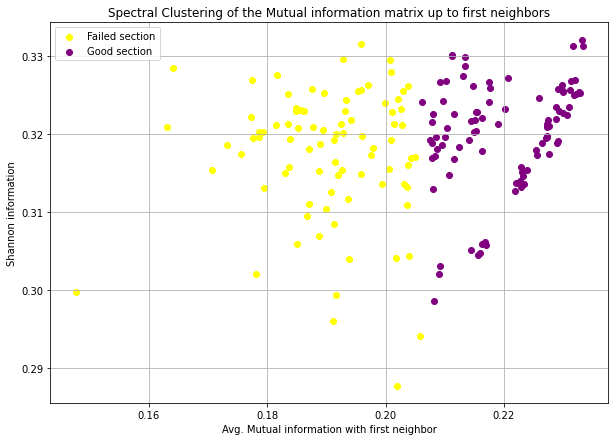

In [22]:
spc = SpectralClustering(n_clusters=2)
y_pred,_ = cluster_filter(spc,minf_sym_benchmark,ids,"Spectral Clustering",do_scatter_plot = True)

In [23]:
print(accuracy_score(Y,y_pred))
print(precision_score(Y,y_pred))
print(recall_score(Y,y_pred))

0.7111111111111111
0.9574468085106383
0.6521739130434783


best:25


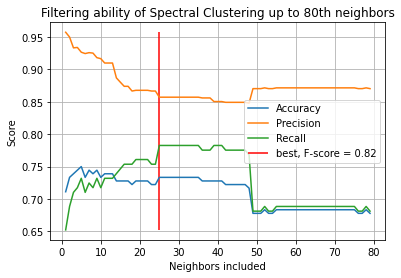

In [24]:
evaluate_neighbors(SpectralClustering(n_clusters=2),minf_sym_benchmark,ids,Y,80,"Spectral Clustering")

## Birch

In [9]:
from sklearn.cluster import Birch

021_IR_rec00000193.png
021_IR_rec00000194.png
021_IR_rec00000195.png
021_IR_rec00000196.png
021_IR_rec00000197.png
021_IR_rec00000200.png
021_IR_rec00000204.png
021_IR_rec00000206.png
021_IR_rec00000209.png
021_IR_rec00000212.png
021_IR_rec00000213.png
021_IR_rec00000215.png
021_IR_rec00000216.png
021_IR_rec00000219.png
021_IR_rec00000220.png
021_IR_rec00000225.png
021_IR_rec00000230.png
021_IR_rec00000231.png
021_IR_rec00000233.png
021_IR_rec00000234.png
021_IR_rec00000242.png
021_IR_rec00000249.png
021_IR_rec00000252.png
021_IR_rec00000254.png
021_IR_rec00000256.png
021_IR_rec00000263.png
021_IR_rec00000264.png
021_IR_rec00000266.png
021_IR_rec00000274.png
021_IR_rec00000277.png
021_IR_rec00000279.png
021_IR_rec00000281.png
021_IR_rec00000306.png
021_IR_rec00000320.png
021_IR_rec00000323.png
021_IR_rec00000328.png
021_IR_rec00000330.png
021_IR_rec00000332.png
021_IR_rec00000338.png
021_IR_rec00000352.png
021_IR_rec00000354.png
021_IR_rec00000359.png
021_IR_rec00000361.png
021_IR_rec0

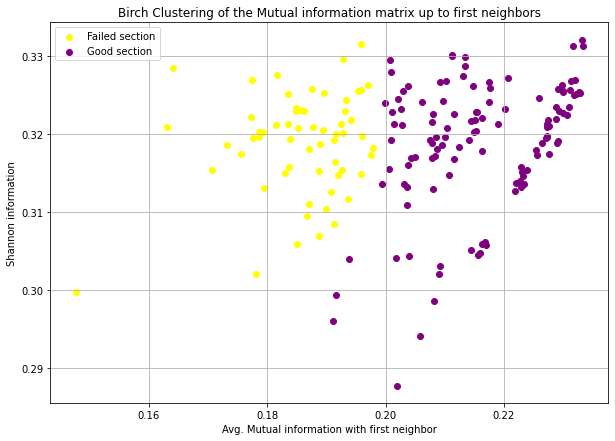

In [26]:
b = Birch(n_clusters=2,threshold=0.01)
y_pred,_ = cluster_filter(b,minf_sym_benchmark,ids,"Birch Clustering",do_scatter_plot = True)

In [27]:
print(accuracy_score(Y,y_pred))
print(precision_score(Y,y_pred))
print(recall_score(Y,y_pred))

0.7333333333333333
0.875
0.7608695652173914


best:4


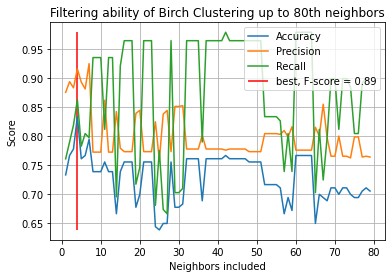

In [28]:
evaluate_neighbors(Birch(n_clusters=2,threshold=0.01),minf_sym_benchmark,ids,Y,80,"Birch Clustering")

## AgglomerativeClustering

In [10]:
from sklearn.cluster import AgglomerativeClustering

021_IR_rec00000193.png
021_IR_rec00000194.png
021_IR_rec00000195.png
021_IR_rec00000196.png
021_IR_rec00000197.png
021_IR_rec00000200.png
021_IR_rec00000204.png
021_IR_rec00000209.png
021_IR_rec00000212.png
021_IR_rec00000213.png
021_IR_rec00000215.png
021_IR_rec00000216.png
021_IR_rec00000219.png
021_IR_rec00000220.png
021_IR_rec00000225.png
021_IR_rec00000230.png
021_IR_rec00000231.png
021_IR_rec00000233.png
021_IR_rec00000234.png
021_IR_rec00000247.png
021_IR_rec00000249.png
021_IR_rec00000252.png
021_IR_rec00000254.png
021_IR_rec00000256.png
021_IR_rec00000264.png
021_IR_rec00000266.png
021_IR_rec00000277.png
021_IR_rec00000279.png
021_IR_rec00000281.png
021_IR_rec00000282.png
021_IR_rec00000284.png
021_IR_rec00000303.png
021_IR_rec00000320.png
021_IR_rec00000323.png
021_IR_rec00000328.png
021_IR_rec00000330.png
021_IR_rec00000332.png
021_IR_rec00000338.png
021_IR_rec00000346.png
021_IR_rec00000348.png
021_IR_rec00000352.png
021_IR_rec00000354.png
021_IR_rec00000359.png
021_IR_rec0

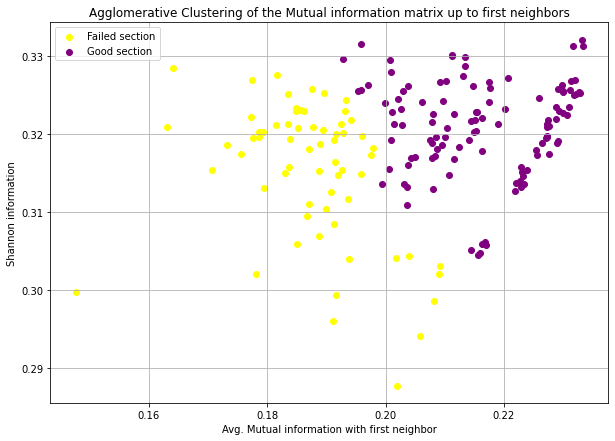

In [30]:
agg = AgglomerativeClustering(n_clusters=2)
y_pred,_ = cluster_filter(agg,minf_sym_benchmark,ids,"Agglomerative Clustering",do_scatter_plot = True)

In [31]:
print(accuracy_score(Y,y_pred))
print(precision_score(Y,y_pred))
print(recall_score(Y,y_pred))

0.7833333333333333
0.9304347826086956
0.7753623188405797


best:5


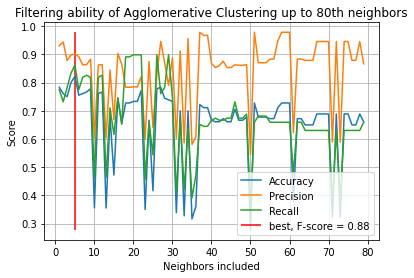

In [33]:
evaluate_neighbors(AgglomerativeClustering(n_clusters=2),minf_sym_benchmark,ids,Y,80,"Agglomerative Clustering")

## Comparison

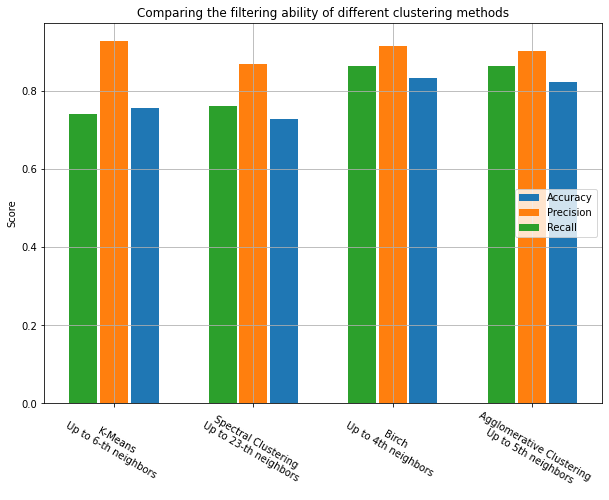

In [34]:
accs = []
prcs = []
rclls = []

models = [KMeans(n_clusters=2),SpectralClustering(n_clusters=2),Birch(n_clusters=2,threshold=0.01),AgglomerativeClustering(n_clusters=2)]
neighbors = [6,23,4,5]
model_names = model_names = ["K-Means\nUp to 6-th neighbors","Spectral Clustering\nUp to 23-th neighbors","Birch\nUp to 4th neighbors","Agglomerative Clustering\nUp to 5th neighbors"]

for m,n in zip(models,neighbors):
    y_pred,_ = cluster_filter_n(m,minf_sym_benchmark,ids,neighbors=n)
    accs.append(accuracy_score(Y,y_pred))
    prcs.append(precision_score(Y,y_pred))
    rclls.append(recall_score(Y,y_pred))
    
plt.figure(figsize=(10,7))
xvals = np.array([0,1,2,3])
plt.bar(xvals+0.22,accs,0.2,label = "Accuracy")
plt.bar(xvals,prcs,0.2,label = "Precision")
plt.bar(xvals-0.22,rclls,0.2,label = "Recall")

plt.title("Comparing the filtering ability of different clustering methods")
plt.ylabel("Score")
plt.legend(loc="center right")
plt.xticks(ticks = xvals,rotation=-30,labels=model_names)
#plt.yticks(ticks=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
plt.grid()

# Filtering the Real Images

## Create padded images

In [3]:
from prepare_for_homography import prepare_images

In [4]:
ids = next(os.walk(f"{DATA_PATH}predicted_thresholded"))[2]
print("No. of images = ", len(ids))

No. of images =  68


In [ ]:
source_path = f'{DATA_PATH}predicted_thresholded/'
target_path = f'{DATA_PATH}predicted_padded/'
prepare_images(ids,source_path,target_path)

In [ ]:
source_path = f'{DATA_PATH}predicted_reconstructed/'
target_path = f'{DATA_PATH}predicted_padded/preds/'
prepare_images(ids,source_path,target_path,color_mode=True,border_value=(255,0,0))

In [ ]:
source_path = f'{DATA_PATH}image_tiles/reconstructed/'
target_path = f'{DATA_PATH}predicted_padded/raw/'
prepare_images(ids,source_path,target_path)

In [ ]:
source_path = f'{DATA_PATH}image_tiles/reconstructed/'
target_path = f'{DATA_PATH}predicted_padded/raw_color/'
prepare_images(ids,source_path,target_path,color_mode=True)

In [5]:
source_path = f'{DATA_PATH}roi_tiles/reconstructed/'
target_path = f'{DATA_PATH}predicted_padded/roi/'
prepare_images(ids,source_path,target_path,color_mode=False,border_value=(0,0,0))

Finding optimal canvas size.


100%|███████████████████████████████████████████████████████████████████████████████████| 68/68 [00:13<00:00,  5.12it/s]


Padding images.


100%|███████████████████████████████████████████████████████████████████████████████████| 68/68 [00:29<00:00,  2.31it/s]

Done.


## Filtering

In [11]:
infile = open(f'{DATA_PATH}minf_sym_raw.pickle','rb')
minf_sym_raw = pickle.load(infile)
infile.close()
minf_sym_raw = minf_sym_raw+minf_sym_raw.T-np.eye(len(minf_sym_raw))*minf_sym_raw

In [12]:
ids = next(os.walk(f"{DATA_PATH}predicted_padded/"))[2]
print("No. of images = ", len(ids))

No. of images =  68


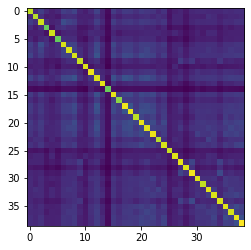

In [13]:
plt.imshow(minf_sym_raw[29:,29:])

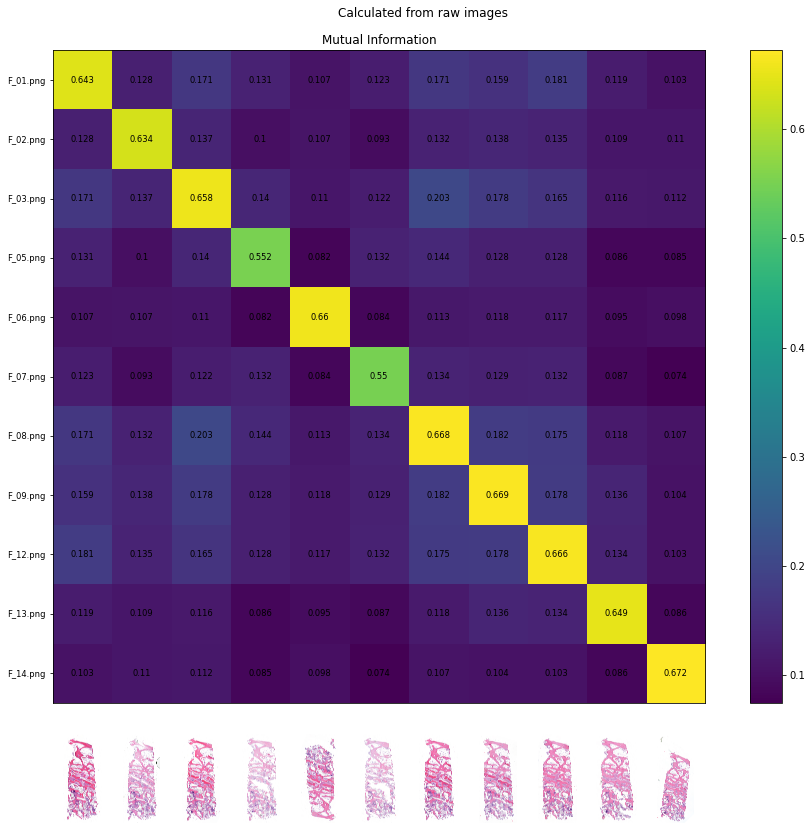

In [14]:
min_num = 29
max_num = 40
imshow_with_numbers(minf_sym_raw[min_num:max_num,min_num:max_num],ids[min_num:max_num],"Calculated from raw images",f'{DATA_PATH}source_files/')

In [15]:
Y = np.array([1.,0.,1.,0.,0.,0.,1.,1.,1.,1.,0.,1.,1.,0.,0.,1.,0.,1.,1.,1.,1.,1.,1.,0.,1.,0.,1.,1.,1.,1.,1.,0.,1.,0.,1.,1.,1.,1.,1.])

In [16]:
F_series = minf_sym_raw[29:,29:]

best:12


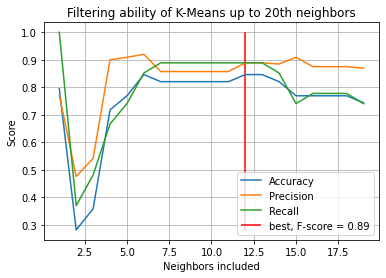

best:1


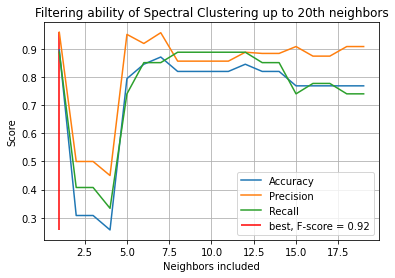

best:10


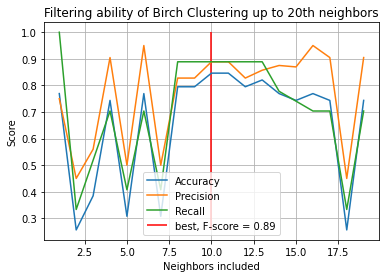

best:10


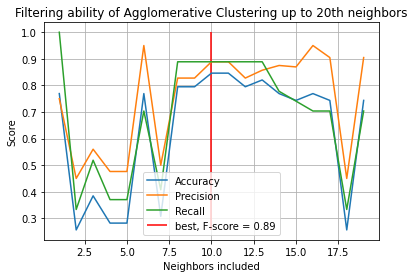

In [23]:
models = [KMeans(n_clusters=2),SpectralClustering(n_clusters=2),Birch(n_clusters=2,threshold=0.01),AgglomerativeClustering(n_clusters=2)]
model_names = ["K-Means","Spectral Clustering","Birch Clustering","Agglomerative Clustering"]

for m,n in zip(models,model_names):
    evaluate_neighbors(m,F_series,ids[29:],Y,20,n)

KMeans(n_clusters=2)
0.8461538461538461
0.8888888888888888
0.8888888888888888
SpectralClustering(n_clusters=2)
0.8974358974358975
0.96
0.8888888888888888
Birch(n_clusters=2, threshold=0.01)
0.8461538461538461
0.8888888888888888
0.8888888888888888
AgglomerativeClustering()
0.8461538461538461
0.8888888888888888
0.8888888888888888


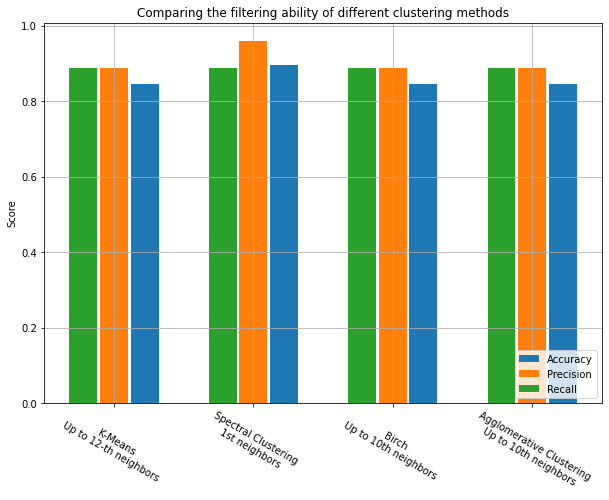

In [27]:
accs = []
prcs = []
rclls = []

models = [KMeans(n_clusters=2),SpectralClustering(n_clusters=2),Birch(n_clusters=2,threshold=0.01),AgglomerativeClustering(n_clusters=2)]
neighbors = [12,1,10,10]
model_names = ["K-Means\nUp to 12-th neighbors","Spectral Clustering\n1st neighbors","Birch\nUp to 10th neighbors","Agglomerative Clustering\nUp to 10th neighbors"]

for m,n in zip(models,neighbors):
    y_pred,_ = cluster_filter_n(m,F_series,ids[29:],neighbors=n)
    print(m)
    print(accuracy_score(Y,y_pred))
    print(precision_score(Y,y_pred))
    print(recall_score(Y,y_pred))
    accs.append(accuracy_score(Y,y_pred))
    prcs.append(precision_score(Y,y_pred))
    rclls.append(recall_score(Y,y_pred))
    
plt.figure(figsize=(10,7))
xvals = np.array([0,1,2,3])
plt.bar(xvals+0.22,accs,0.2,label = "Accuracy")
plt.bar(xvals,prcs,0.2,label = "Precision")
plt.bar(xvals-0.22,rclls,0.2,label = "Recall")

plt.title("Comparing the filtering ability of different clustering methods")
plt.ylabel("Score")
plt.legend(loc="lower right")
plt.xticks(ticks = xvals,rotation=-30,labels=model_names)
#plt.yticks(ticks=[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
plt.grid()

F_01.png
F_02.png
F_05.png
F_06.png
F_07.png
F_13.png
F_14.png
F_19.png
F_21.png
F_29.png
F_32.png
F_33.png
F_38.png


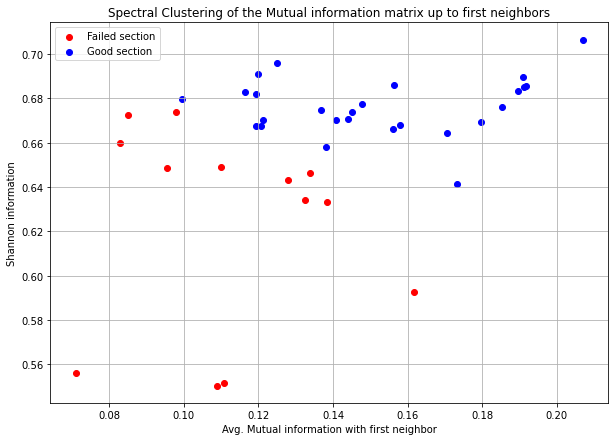

In [26]:
preds, drop_list = cluster_filter(SpectralClustering(n_clusters=2),F_series,ids[29:],"Spectral Clustering",do_scatter_plot = True)

In [31]:
#this one was missing
drop_list.append('F_41.png')

In [34]:
outfile = open(f"{DATA_PATH}F_series_drop_list.pickle","wb")
pickle.dump(drop_list,outfile)
outfile.close()